# Hazard assessment for heavy snowfall & blizzards

Click [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/CLIMAAX/DROUGHTS/main?labpath=DROUGHTS_notebook_2.ipynb) to launch this workflow on MyBinder. 


## Hazard assessment methodology

In this workflow, our aim is to understand the present probability of severe snowfall and blizzards and pinpoint the particular regions in Europe that are highly impacted.

### Blizzard  

A blizzard is a severe storm condition defined by low temperature, sustained wind or frequent wind gust and considerable precipitating or blowing snow. For blizzard conditions we propose the use of following impact indicator:

**Blizzard days** = Tmean  ≤ 0 °C, Rs (snow amount) ≥ 10 cm and Wg (wind gust) ≥ 17 m/s ( Vajda et al., 2014). 

This impact indicator was defined taking into account the exposure of critical infrastructure, i.e., roads, rails, power lines, telecommunication to the hazard and is based on an extensive literature review, media reports, surveys conducted with European CI operators and case studies. 


### Heavy Snow 

Heavy snowfall may cause many disruptions and impacts in various sectors; however, the impacts and consequences of this hazard depend on the affected sector, infrastructure and also preparedness of society that varies over Europe.  For example, already a few centimeters of snow can disrupt road traffic, but doesn’t normally cause any harm to energy infrastructure. Many weather services have three warning levels based on the severity of expected impacts, which are typically different for different sectors of infrastructure. There is a large variation in the national warning criteria or thresholds.

Similarly to blizzard, the impact indicators for heavy snowfall were defined taking into account the exposure of critical infrastructure, i.e., roads, rails, power lines, telecommunication to the hazard and is based on an extensive literature review, media reports, surveys conducted with European CI operators and case studies. The qualitative description of the two-level thresholds are:

**1st threshold ( > 6 cm):** Some adverse impacts are expected, their severity depends on the resilience of the system, transportation is mainly affected.

**2nd threshold ( > 25 cm):**  The weather phenomena are so severe that is likely that adverse impact will occur, CI system is seriously impacted.

This code calculates the Annual probability (%) of a blizzard and heavy snowfall days during the specified period and a region of interest.


**The annual probability is calualted using following equation**

P =    ((variable > threshold) / days in year ) X 100


## Preparation work

### Select area of interest
Before downloading the data, we will define the coordinates of the area of interest. Using these coordinates, we can clip the datasets for further processing and generate hazard maps for the selected area. Please specify a name for this area, which will be used in plots and saved results

 area = [Lat_north, Lon_east, Lat_south, Lon_west,]

In [26]:
# Lat Lon for area interest
area = [80, -10, 20, 45,]
areaname = 'Europe'

### Load libraries

In this notebook we will use the following Python libraries:
- [warnings](https://docs.python.org/3/library/warnings.html) - To control the Python warning message 
- [cdsapi](https://pypi.org/project/cdsapi/) - To access the  CDS data
- [os](https://docs.python.org/3/library/os.html) - To create directories and work with files
- [pathlib](https://docs.python.org/3/library/pathlib.html) - To create Object-oriented filesystem paths
- [pooch](https://www.fatiando.org/pooch/latest/index.html) - To download and unzip the data
- [urllib](https://docs.python.org/3/library/urllib.html) - package for working with URLs
- [xarray](https://docs.xarray.dev/en/stable/) - To process the NetCDF data and prepare it for further calculation
- [xclim](https://xclim.readthedocs.io/en/stable/installation.html) - To correct the required data units
- [xesmf](https://xesmf.readthedocs.io/en/stable/) - Universal regridder for geospatial data
- [rioxarray](https://corteva.github.io/rioxarray/stable/) - Rasterio xarray extension - to make it easier to use GeoTIFF data with xarray
- [rasterio](https://rasterio.readthedocs.io/en/stable/) - To access and explore geospatial raster data in GeoTIFF format
- [np](https://numpy.org) - Numerical computing tools  
- [matplotlib](https://matplotlib.org/) - To plot the maps 
- [cartopy](https://scitools.org.uk/cartopy/docs/latest/) - To plot the maps



In [27]:
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

import cdsapi
import os
from pathlib import Path
import pooch
from urllib.request import urlopen

import xarray as xr
import xclim as xc
import xesmf as xe
import rioxarray as rxr
import numpy as np

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

##  Create the directory structure 

In order for this workflow to work even if you download and use just this notebook, we need to set up the directory structure.
Next cell will create the directory called 'snow_workflow' in the same directory where this notebook is saved.


In [3]:
workflow_folder = 'SNOW_hazard'
if not os.path.exists(workflow_folder):
    os.makedirs(workflow_folder)

In [29]:
data_dir = os.path.join(workflow_folder,f'data_{areaname}')
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

plot_dir = os.path.join(workflow_folder,f'plots_{areaname}')
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

## Access and view dataset

#### Download ERA5 and load data into memory

We downloaded [ERA5 single level dataset](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview)  using the CDS API from the [Copernicus Climate Data Store](https://cds.climate.copernicus.eu/#!/home). We require several variables to calculate these indicator, which are at an hourly frequency. Consequently, this analysis is limited to the data period from 1991 to 2010.

We are currently retrieving data for demonstration purposes only at 00:00, 06:00, 12:00, and 18:00 UTC. However, it is feasible to obtain data for all 24 time steps. It is important to mention that we are focusing on only 4-time steps with a 6-hour interval. However, the variable "wind gust" displays the value from one hour before rather than 6 hours. Nevertheless, it remains a reliable representation.

In [5]:
c = cdsapi.Client()

day_range=np.arange(1,32)
month_range=np.array((1,2,3,10,11,12))
varnames=['2m_temperature','10m_wind_gust_since_previous_post_processing','snow_depth','snow_density']
dataset = 'reanalysis-era5-single-levels'

# API request
params = {'format': 'netcdf',
        'product_type': 'reanalysis',
        'variable': varnames,
        'year': list(map(str, range(1991, 2010))),
        'month': list(map("{:02d}".format, range(1,13))),
        'time': ['00:00', '06:00', '12:00', '18:00', ],
        'day': list(np.char.zfill(list(map(str, day_range)),2)),
        'grid': [0.25, 0.25],
        'area':area,}

# retrieve the location of the file
fl = c.retrieve(dataset, params)

# load into memory
with urlopen(fl.location) as f:
    ds = xr.open_dataset(f.read())

2024-02-16 05:05:11,894 INFO Welcome to the CDS
2024-02-16 05:05:11,896 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2024-02-16 05:05:12,050 INFO Request is queued
2024-02-16 09:26:52,408 INFO Request is completed


## Process the ERA5 data

#### Convert unit of input variables 
Temperature (Kelvin) --> Temperature -273.15 (deg C)

Snow depth  (m of water equivalent)  -->Snow depth (cm) 

   Snow depth (m) = (RW X SD) / RSN
   
     where:
      SD= snow depth in m of water equivalent
      RW, density of water, = 1000 kg/m3
      RSN = density of snow in kg/m3
 Snow depth (cm) --> Snow depth (m) X 100

In [9]:
ds['t2m']  = xc.units.convert_units_to(ds.t2m, "degC")

ds['snow_depth'] = 1000 * ds.sd / ds.rsn
ds = ds.drop(['sd','rsn'])
ds['snow_depth'] = ds.snow_depth.assign_attrs(units="m", description="snow depth")
ds['snow_depth'] = xc.units.convert_units_to(ds.snow_depth, "cm")

####  Resampling to daily data

According to the ERA5 convention, accumulated variables aggregate data from 00 UTC to the next 24 hours (i.e., the accumulation at 00 UTC represents the sum of values during the previous day). Therefore, before archiving accumulated variables, we shifted the time axis by one timestep to ensure that the accumulations at 00 UTC correspond to the actual day.


In [10]:
ds = ds.shift(time=1)

tas_day        = ds.t2m.resample(time='24H').mean('time')
wspd_day       = ds.fg10.resample(time='24H').max('time')
snow_depth_day = ds.snow_depth.resample(time='24H').mean('time')

### The Heavy snowfall & blizzards Indicator


### Define thresholds 

**Thresholds for Blizzard days**

Temperature threshold --> lim_tas    = 0.

Snow threshold          -->lim_snow10 = 10.

Wind gust threshold   -->lim_gust   = 17.


**Heavy Snow thresholds** 

Snow exceding 6cm threshold  -->lim_snow6  = 6.

Snow exceding 25cm threshold -->lim_snow25 = 25.

In [11]:
#| Define thresholds 
lim_tas    = 0.
lim_snow10 = 10.
lim_gust   = 17.

lim_snow6  = 6.
lim_snow25 = 25.

#### Calculate the probability of occurence

In [31]:
#| The probability of occurrence of at least one blizzard day

BdayCount_anaProb = ((tas_day
                      < lim_tas) * (snow_depth_day > lim_snow10) * (wspd_day > lim_gust)).groupby('time.year').sum('time')
#del tas_day, wspd_day
total_days_per_year = snow_depth_day.groupby('time.year').count(dim='time')

BdayCount_anaProb = (BdayCount_anaProb / total_days_per_year) * 100

BdayCount_anaProb = BdayCount_anaProb.where(BdayCount_anaProb != 0.)
BdayCount_anaProb = BdayCount_anaProb.assign_attrs(units="%", long_name="Annual probability of blizzard days")
BdayCount_anaProb = BdayCount_anaProb.to_dataset(name='blizzard_days')

BdayCount_anaProb_mean = BdayCount_anaProb.mean('year')

BdayCount_anaProb_mean.to_netcdf(path=os.path.join(data_dir, "BdayCount_AnaProb_mean.nc"))
del BdayCount_anaProb


#| Probability of occurrence of at least one day with snowfall > 6cm

snow6Count_anaProb = (snow_depth_day > lim_snow6).groupby('time.year').sum('time')

snow6Prob_annual = (snow6Count_anaProb / total_days_per_year) * 100

snow6Prob_annual = snow6Prob_annual.where(snow6Prob_annual != 0.)
snow6Prob_annual = snow6Prob_annual.assign_attrs(units="%", long_name="Annual probability of snow days")
snow6Prob_annual = snow6Prob_annual.to_dataset(name='snow_days')

snow6Prob_annual_mean = snow6Prob_annual.mean('year')
snow6Prob_annual_mean.to_netcdf(path=os.path.join(data_dir, "snow6Prob_annual_mean.nc"))
del snow6Prob_annual


#| Probability of occurrence of at least one day with snowfall > 25cm
snow25Count_anaProb = (snow_depth_day > lim_snow25).groupby('time.year').sum('time')

snow25Prob_annual = (snow25Count_anaProb / total_days_per_year) * 100

snow25Prob_annual = snow25Prob_annual.where(snow25Prob_annual != 0.)
snow25Prob_annual = snow25Prob_annual.assign_attrs(units="%", long_name="Annual probability of snow days")
snow25Prob_annual = snow25Prob_annual.to_dataset(name='snow_days')

snow25Prob_annual_mean = snow25Prob_annual.mean('year')
snow25Prob_annual_mean.to_netcdf(path=os.path.join(data_dir, "snow25Prob_annual_mean.nc"))
del snow25Prob_annual

## Visualize the hazard data
Having acquired the data and computed the required indicator, we proceed to create visual plots for data exploration. 

### Annual probability plot of indicator


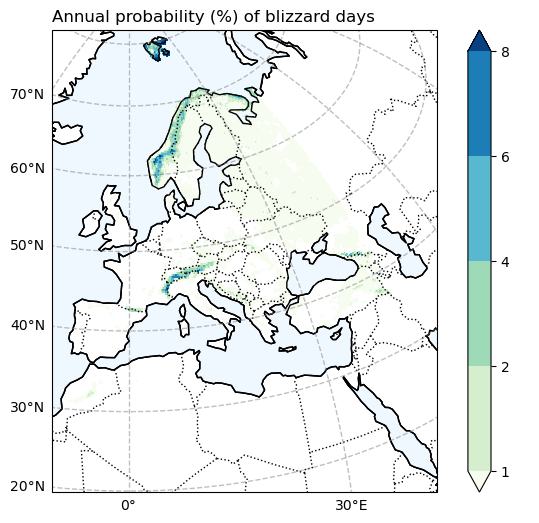

In [15]:
np.warnings.filterwarnings('ignore')
fig = plt.figure(figsize=(8, 6))
p_levels = [ 1,2,4, 6,8]

p = BdayCount_anaProb_mean.blizzard_days.plot(
    subplot_kws=dict(projection=ccrs.Orthographic(0, 35)),
    levels=p_levels, 
    cbar_kwargs={"label": "  "},
    cmap="GnBu",
    transform=ccrs.PlateCarree(),
)
p.axes.coastlines()
plt.title('Annual probability (%) of blizzard days', loc = "left")

# Add coastlines and features

p.axes.add_feature(cfeature.BORDERS, linestyle=':')
p.axes.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
p.axes.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='aliceblue')

# Add latitude and longitude labels
gl = p.axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

fileout = os.path.join(plot_dir,'Annual_probability_of_blizzard_days.png'.format(areaname))
fig.savefig(fileout) 

plt.show()

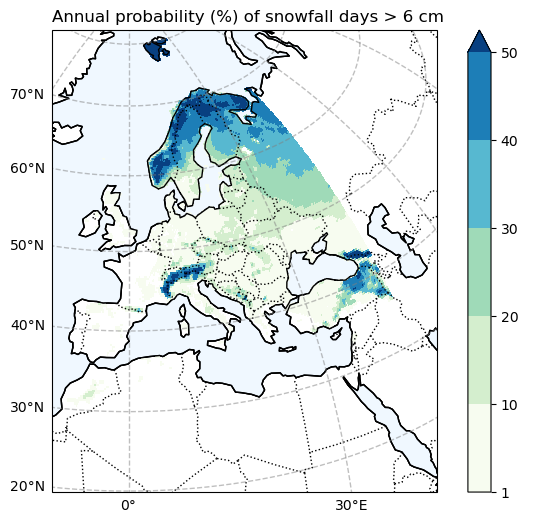

In [32]:
# Filter the data to exclude values less than 1
filtered_data = snow6Prob_annual_mean.snow_days.where(snow6Prob_annual_mean.snow_days >= 1)

fig = plt.figure(figsize=(8, 6))
p_levels = [1, 10, 20, 30, 40, 50]

p = filtered_data.plot(
    subplot_kws=dict(projection=ccrs.Orthographic(0, 35)),
    levels=p_levels,
    cmap="GnBu",
    cbar_kwargs={"label": " "},
    transform=ccrs.PlateCarree(),
)

p.axes.coastlines()
plt.title('Annual probability (%) of snowfall days > 6 cm  ', loc="left")

# Add coastlines and features
p.axes.add_feature(cfeature.BORDERS, linestyle=':')
p.axes.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
p.axes.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='aliceblue')

# Add latitude and longitude labels
gl = p.axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
fileout = os.path.join(plot_dir,'Annual_probability_of_snowfall_days_6cm.png'.format(areaname))
fig.savefig(fileout) 

plt.show()

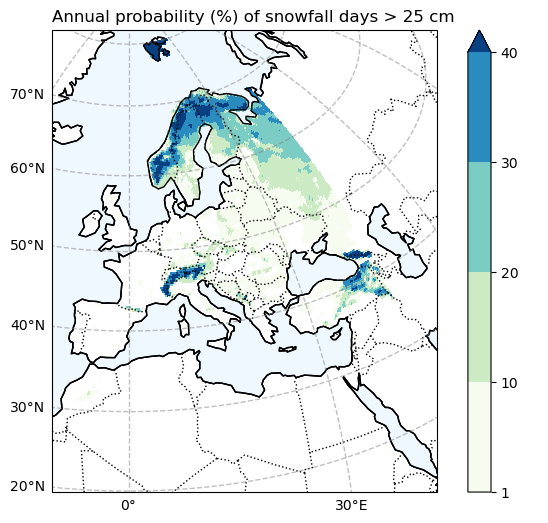

In [17]:
# Filter the data to exclude values less than 1
filtered_data = snow25Prob_annual_mean.snow_days.where(snow25Prob_annual_mean.snow_days >= 1)

fig = plt.figure(figsize=(8, 6))
p_levels = [1, 10, 20, 30, 40]

p = filtered_data.plot(
    subplot_kws=dict(projection=ccrs.Orthographic(0, 35)),
    levels=p_levels,
    cmap="GnBu",
    cbar_kwargs={"label": " "},
    transform=ccrs.PlateCarree(),
)

p.axes.coastlines()
plt.title('Annual probability (%) of snowfall days > 25 cm  ', loc="left")

# Add coastlines and features
p.axes.add_feature(cfeature.BORDERS, linestyle=':')
p.axes.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
p.axes.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='aliceblue')

# Add latitude and longitude labels
gl = p.axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
fileout = os.path.join(plot_dir,'Annual_probability_of_snowfall_days_25cm.png'.format(areaname))
fig.savefig(fileout) 

plt.show()

## Conclusions
In this workflow, we have demonstrated the procedure of exploring, processing, and visualizing the data required for snow and blizzard calculation.

These indices represent annual probabilities, indicating the likelihood of specific events occurring over multiple years.

The snow and blizzard hazard maps obtained and saved locally in this workflow will be utilized in the subsequent snow and blizzard risk workflow, which is a component of the risk toolbox.

## Contributors
Suraj Polade, Finnish Meteorological Institute

Andrea Vajda, Finnish Meteorological Institute